# TRABAJO PRÁCTICO 4 - KNN Y ANÁLISIS DEL DISCRIMINANTE

In [965]:
#librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import pairplot 
from sklearn import model_selection as ms
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score 

# Exploración de datos

(211, 11)
(211,)
3


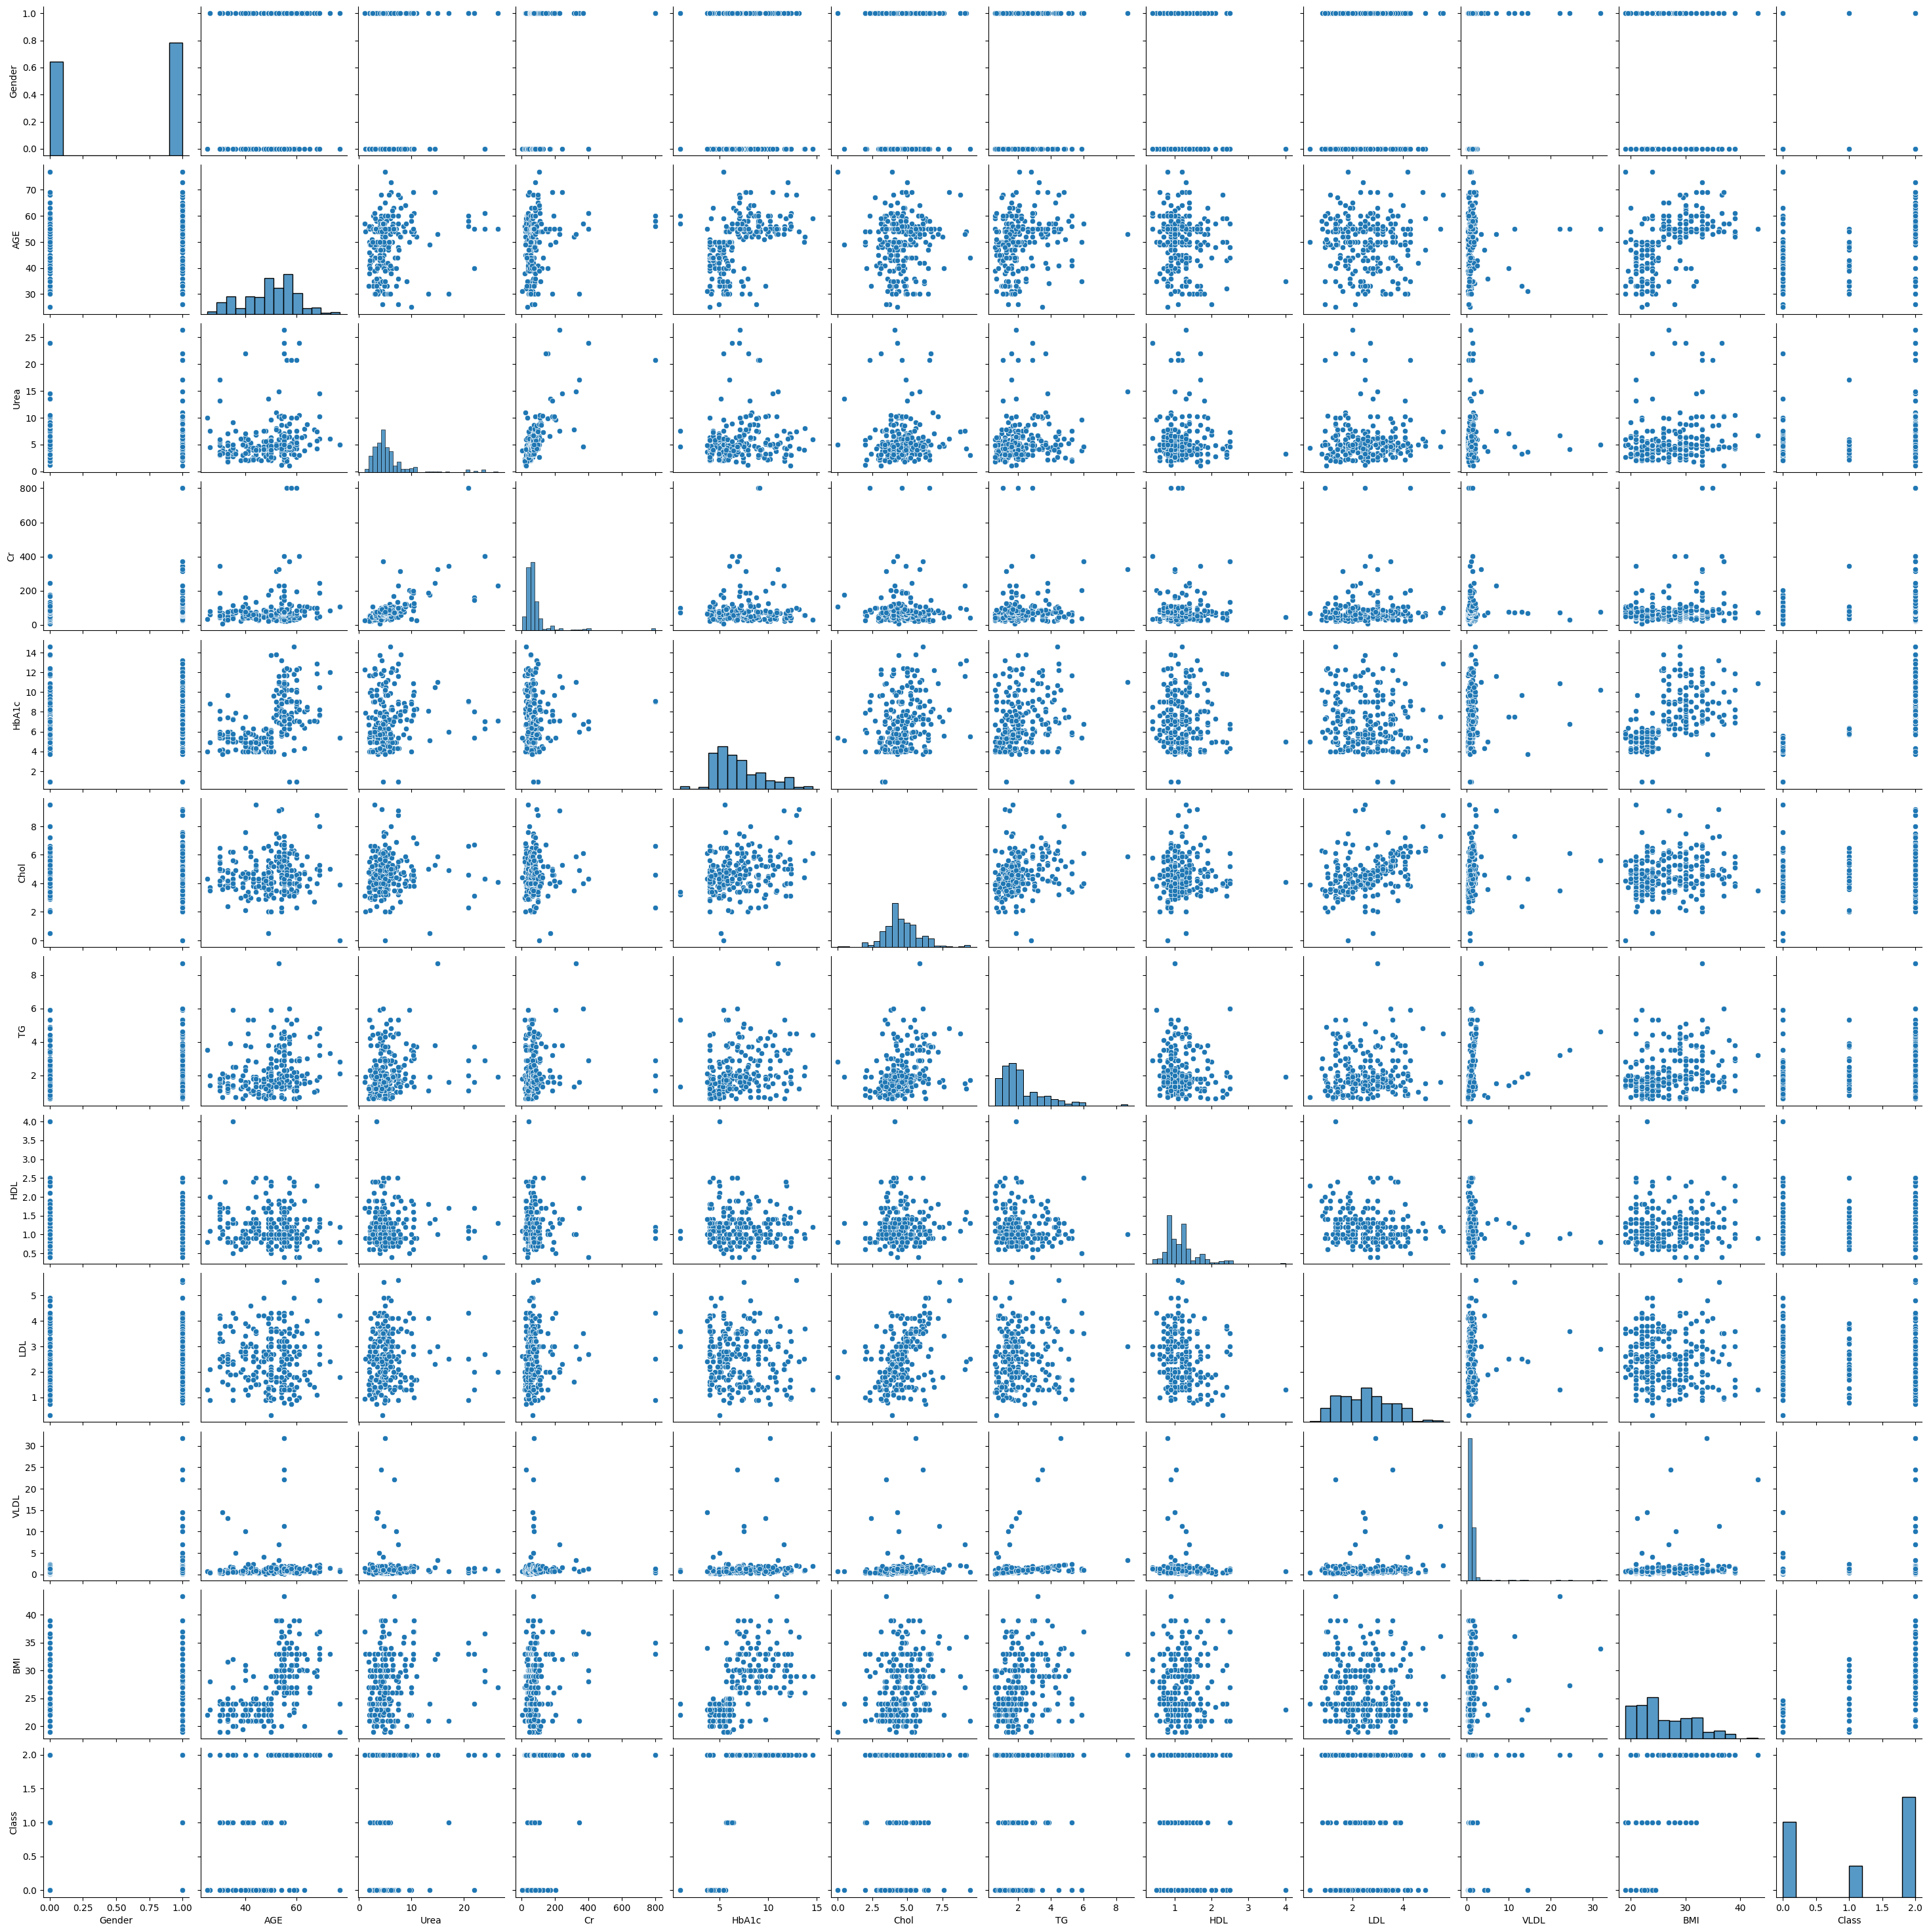

In [966]:
#Se cargan los datos del csv
df = pd.read_csv('MulticlassDiabetesDataset.csv')

p_test = 0.2
p_train = 0.8

#Cantidad de muestras por clase
# print(df.shape[0])

#Gráfico con pairplot
pairplot(df)

#Se definen los conjuntos de entrenamiento y testeo 
[train,test] = ms.train_test_split(df, train_size = p_train ,test_size = p_test)

y_train=train['Class'].sort_index() #Se selecciona el feature de clase y se ordenan los datos
x_train = train.drop(columns = ['Class']).sort_index() #Se elimina el feature 'Class' de los datos de entrenamiento

y_test = test['Class'].sort_index() #Se selecciona el feature de clase y se ordenan los datos
x_test = test.drop(columns = ['Class']).sort_index() #Se elimina el feature 'Class' de los datos de testeo y se ordenan

n_cat = len(np.unique(y_train)) #Se calcula la longitud de la lista con las apariciones únicas en el feature 'Class'

print(x_train.shape)
print(y_train.shape)
print(n_cat)


# Análisis del discriminante

## Creación de la clase LDA_QDA

In [967]:
class LDA_QDA:
    def __init__ (self, LDA = False, n_cat = 0):
        self.LDA = LDA #Se define si se quiere el modelo LDA o QDA
        self.n_cat = n_cat #Cantidad de categorías en el problema
        self.D = None #Conjuntos de datos correspondientes a cada clase
        self.c = None #Probabilidades a priori
        self.sigma = None #Matriz de covarianza para cada clase
        self.sigma_lda = None #Matriz de covarianza para LDA - Común para todas las clases

    # Entrenamiento
    def fit (self, X, y):
        
        #Se separan las muestras que corresponden a cada categoría en D (D_k)
        self.D = [X[y==i] for i in range(self.n_cat)]

        n_samples = X.shape[0] #Se guarda la cantidad de muestras
        self.c = []
        self.mu = []
        self.sigma = []
        
        if self.LDA == True:
            self.sigma_lda = [] 

        for i in range(self.n_cat):
            #Se calculan las constantes para cada conjunto
            self.c.append( self.D[i].shape[0]/n_samples )

            #Se calcula la media de cada categoría en cada feature
            self.mu.append(np.mean(self.D[i], axis=0).reshape(-1))

            #Se calcula sigma para cada categoría
            diff = self.D[i] - self.mu[i]
            self.sigma.append( np.atleast_2d( (1/(self.D[i].shape[0]-1)) * diff.T @ diff ) ) #Se crea para que tenga por lo menos 2 dimensiones para poder tratar con 1 feature (dim,1) 

            #Se calcula el sigma que se utiliza en el método LDA para cada categoría
            if self.LDA == True:
                self.sigma_lda.append( np.atleast_2d( (1/(n_samples-self.n_cat)) * (self.D[i].shape[0] -1 ) * self.sigma[i] ) ) #Se crea para que tenga por lo menos 2 dimensiones para poder tratar con 1 feature (dim,1)
        
        if self.LDA == True:
            #Se calcula el sigma resultante para utilizar en LDA tras el calculo por categorías
            self.sigma_lda = np.atleast_2d( np.sum(self.sigma_lda,axis = 0) ) #Se crea para que tenga por lo menos 2 dimensiones para poder tratar con 1 feature (dim,1)
            
        #Para visualizar algunos shapes
        # print(len(self.sigma))
        # print(self.sigma_lda[0].shape)
        # print(self.D[0].shape)
        # print(len(self.mu))
        # print(self.D[0].shape)
        # print(self.D[1].shape)
        # print(self.D[2].shape)
        
        
    # Predicción Soft
    def predict_prob (self, X):
        delta = self.predict_discriminant(X)
        exp_delta = np.exp(delta)
        pred_soft = exp_delta / np.sum(exp_delta, axis=1, keepdims=True) #Se calcula la predicción soft, cuidando de hacer la suma en cada fila de forma correcta
        return pred_soft
        

    # Predicción Hard
    def predict (self, X):
        delta = self.predict_discriminant(X)
        pred_hard = np.argmax(delta,axis=1)
        return pred_hard


    # Alternativa práctica para el testeo soft - Cálculo del discriminante para las muestras X
    def predict_discriminant(self, X):
        
        #Se transforman los datos a arrays de numpy
        if hasattr(X, "values"):
            x = X.values #Si es un Series de pandas
        else:
            x = np.array(X) #En otro caso, se fuerza el array de numpy

        if x.ndim == 1: #Si el array tiene la forma (dim,) se lo pasa a vector columna (dim,1), para evitar problemas de dimensiones
            x = x.reshape(-1, 1)
            
            
        delta = np.zeros((x.shape[0], self.n_cat)) #Se crea un array de los deltas de n_muestras x n_categorias
        if self.LDA == True:  
            inv_sigma_lda = np.linalg.inv(self.sigma_lda) #Se calcula la inversa de la matriz sigma para evitar repetir cálculos
            for j in range(x.shape[0]): #Se calcula el discriminante en cada x, en las n_cat
                for i in range(self.n_cat):
                    delta[j,i] = np.log(self.c[i]) + x[j,:].T @ inv_sigma_lda @ self.mu[i] - 0.5 * self.mu[i].T @ inv_sigma_lda @ self.mu[i]
            
        else: 
            for j in range(x.shape[0]): #Se calcula el discriminante para cada muestra en las n features, usando QDA
                for i in range(self.n_cat):
                    diff = x[j,:]-self.mu[i] #Se calcula la diferencia para cada muestra en las n categorías para evitar repetir cálculos
                    delta[j,i] = np.log(self.c[i]) - (0.5) * diff.T @ np.linalg.inv(self.sigma[i]) @ (diff) - 0.5 * np.log(np.linalg.det(self.sigma[i]))
            
        return delta

## Comparación de LDA y QDA para 1 feature

LDA: 
 accuracy = 0.7735849056603774 
 f1_macro = 0.5767195767195767
Matriz de confusión: [[21  0  0]
 [10  0  0]
 [ 2  0 20]]


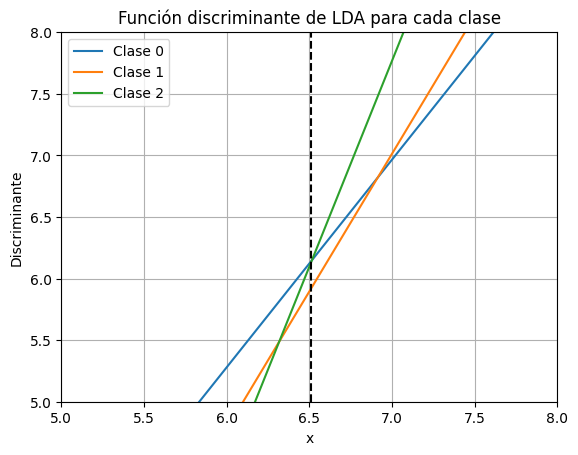

QDA: 
 accuracy = 0.9245283018867925 
 f1_macro = 0.9044390253573623
Matriz de confusión: [[21  0  0]
 [ 0  7  3]
 [ 1  0 21]]


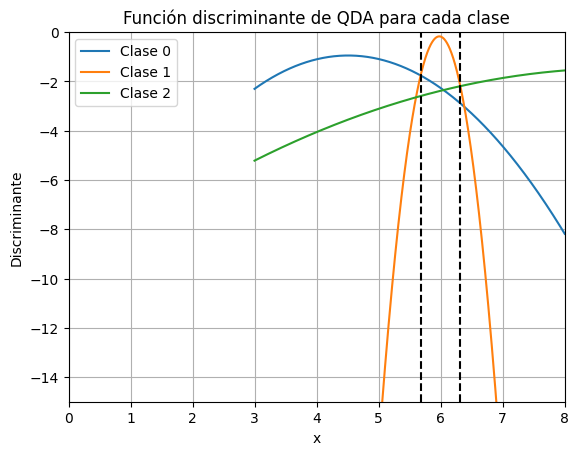

In [968]:
#Se selecciona el feature 'HbA1c' para entrenar el modelo y para las predicciones
selected_feature_train = np.array(x_train['HbA1c'])
# selected_feature_train = selected_feature_train.reshape(-1,1) #Se lo convierte en vector columna 

selected_feature_test = np.array(x_test['HbA1c'])
# selected_feature_test = selected_feature_test.reshape(-1,1) #Se lo convierte en vector columna

#------------------------------------------- LDA
#Se entrena el modelo 
model_lda = LDA_QDA(LDA = True, n_cat = 3)

model_lda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test
x_min, x_max = selected_feature_test.min()-1, selected_feature_test.max()+1
x_graph = np.linspace(x_min, x_max, 2000).reshape(-1,1) #Se obtiene un array de x para graficar el discriminante como vector columna

y_pred_graph = model_lda.predict(x_graph.reshape(-1,1)) #Se obtiene la hard predict para las muestras utilizadas en el gráfico, como vector columna
index = np.where(np.diff(y_pred_graph) != 0)[0] #Se buscan los índices donde se cruzan los discriminantes (valores de la frontera)
x_edge = x_graph[index] #Se asignan las muestras de la frontera

y_pred = model_lda.predict(selected_feature_test)
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')
print(f'Matriz de confusión: {c_matrix}')

#Se obtiene la función discriminante
delta = model_lda.predict_discriminant(x_graph)

plt.figure()
#Se grafica la función discriminante
for i in range(delta.shape[1]):
    plt.plot(x_graph, delta[:,i], label=f"Clase {i}")

#Se grafica la frontera de decisión
for x_e in x_edge:
    plt.axvline(x_e, color='k', linestyle='--')

plt.xlabel('x')
plt.ylabel('Discriminante')
plt.legend()
plt.title('Función discriminante de LDA para cada clase')
plt.xlim([5,8])
plt.ylim([5,8])
plt.grid()
plt.show()






#------------------------------------------- QDA

#Se entrena el modelo 
model_qda = LDA_QDA(n_cat = 3)

model_qda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test
x_min, x_max = selected_feature_test.min()-1, selected_feature_test.max()+1
x_graph = np.linspace(x_min, x_max, 2000).reshape(-1,1) #Se obtiene un array de x para graficar el discriminante como vector columna.


y_pred_graph = model_qda.predict(x_graph.reshape(-1,1)) #Se obtiene la hard predict para las muestras utilizadas en el gráfico (como vector columna)
index = np.where(np.diff(y_pred_graph) != 0)[0] #Se buscan los índices donde se cruzan los discriminantes (valores de la frontera)
x_edge = x_graph[index] #Se asignan las muestras de la frontera


y_pred = model_qda.predict(selected_feature_test)
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'QDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')
print(f'Matriz de confusión: {c_matrix}')

#Se obtiene la función discriminante
delta = model_qda.predict_discriminant(x_graph)

plt.figure()
#Se grafica la función discriminante
for i in range(delta.shape[1]):
    plt.plot(x_graph, delta[:,i],label=f"Clase {i}")

#Se grafica la frontera de decisión
for x_e in x_edge:
    plt.axvline(x_e, color='k', linestyle='--')

plt.xlabel('x')
plt.ylabel('Discriminante')
plt.legend()
plt.title('Función discriminante de QDA para cada clase')
plt.xlim([0,8])
plt.ylim([-15,0])
plt.grid()
plt.show()

##### Sobre la frontera de decisión y el discriminante

Se puede apreciar que LDA clasifica principalmente en las clases 0 y 2, pero prácticamente no hace predicciones sobre la clase 1. Esto se aprecia en la matriz de confusión, donde se puede ver que la clase 1 no tiene aciertos

Por otro lado, QDA contempla las 3 clases en distintos rangos, por lo que tiene sentido pensar que se ajusta mejor a los datos, dado que hay 3 clases en los mismos. Sin embargo, es importante notar que la clase 1 tiene un rango acotado con respecto a las demás. En este caso, esto mismo se evidencia en la matriz de confusión, donde la clase 1 tiene aciertos a diferencia del caso con LDA.

##### Sobre el Accuracy y el Macro-F1

En el caso de LDA, el accuracy y el F1 possen valores distintos.
Eso se debe a que el modelo tiene buena predicción para las clases que predice: Clase 0 y Clase 2, por ello el accuracy que mide la cantidad de aciertos totales con respecto a la cantidad de valores reales, da un valor alto. Pero por otro lado, el Macro-F1 contempla realmente la precisión en la predicción sobre cada clase, es decir, hace un promedio de las predicciones de cada clase y al ser la Clase 1 ignorada, entonces dicho promedio baja y es por eso que discrepan estos parámetros.

Para el caso de QDA, el accuracy es más alto que en el caso de LDA, esto principalmente se debe a que hay una clase no ignorada, generando que la cantidad de aciertos predichos totales con respecto a la totalidad de los valores reales, sean más altos. Por otro lado, esto mismo se denota en Macro-F1, ya que en este se realiza el promedio de las precisiones para cada clase y dado que ninguna de ellas es ignorada, el parámetro Macro-F1 es más alto que en LDA y es similar al accuracy de QDA, por ser el promedio de las precisiones.

## Comparación de LDA y QDA para 2 features

LDA: 
 accuracy = 0.7924528301886793 
 f1_macro = 0.5874125874125874
Matriz de confusión: [[21  0  0]
 [ 9  0  1]
 [ 1  0 21]]


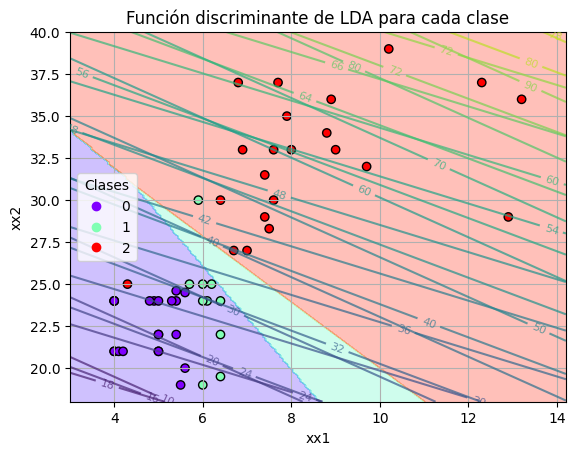

QDA: 
 accuracy = 0.9433962264150944 
 f1_macro = 0.9329888027562445
Matriz de confusión: [[21  0  0]
 [ 2  8  0]
 [ 1  0 21]]


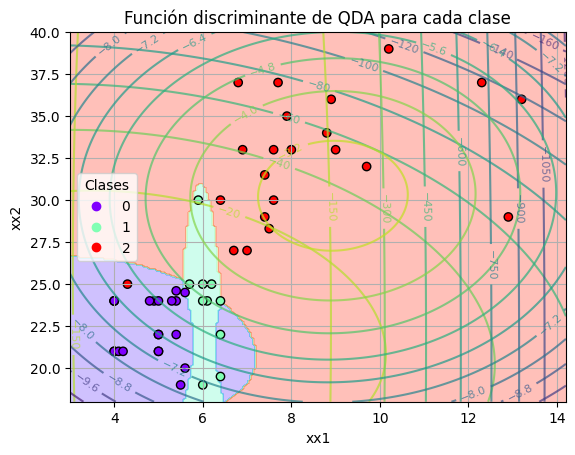

In [969]:
#Se selecciona el feature 'HbA1c' y 'BMI' para entrenar el modelo y para las predicciones
selected_feature_train = np.array(x_train[['HbA1c', 'BMI']])

selected_feature_test = np.array(x_test[['HbA1c', 'BMI']])

#------------------------------------------- LDA

#Se entrena el modelo 
model_lda = LDA_QDA(LDA = True, n_cat = 3)

model_lda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test para cada feature
x1_min, x1_max = selected_feature_test[:,0].min() - 1, selected_feature_test[:,0].max() + 1
x2_min, x2_max = selected_feature_test[:,1].min() - 1, selected_feature_test[:,1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200)) #Se crea la grilla de x para graficar el discriminante en 2D
grid_points = np.c_[xx1.ravel(), xx2.ravel()] #Se ajusta la grilla a la forma (#muestras, 2), es decir, como 2 vectores columna concatenados

y_pred_graph = model_lda.predict(grid_points) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
y_pred_graph = y_pred_graph.reshape(xx1.shape) #Se ajusta el tamaño del vector para tener el mismo shape que las columnas de la grilla

y_pred = model_lda.predict(selected_feature_test) #Predicción de los valores reales del test
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')
print(f'Matriz de confusión: {c_matrix}')

#Se obtiene la función discriminante
delta = model_lda.predict_discriminant(grid_points)

plt.figure()
#Se grafican las fronteras de decisión y las muestras originales con su pertenencia a cada clase
plt.contourf(xx1, xx2, y_pred_graph, alpha=0.3, cmap='rainbow')
scatter = plt.scatter(selected_feature_test[:,0], selected_feature_test[:,1], c=y_test, edgecolor='k', cmap = 'rainbow')

for i in range(delta.shape[1]): #Se grafican las curvas de nivel de la función discriminante
    d = delta[:, i].reshape(xx1.shape)
    cl= plt.contour(xx1, xx2, d, levels=10, alpha=0.7)
    plt.clabel(cl, inline=True, fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clases")
plt.xlabel('xx1')
plt.ylabel('xx2')
plt.title('Función discriminante de LDA para cada clase')
plt.grid()
plt.show()






#------------------------------------------- QDA

#Se entrena el modelo 
model_qda = LDA_QDA(n_cat = 3)

model_qda.fit(selected_feature_train,y_train)

#Se calcula el mínimo y el máximo de los valores de test para cada feature
x1_min, x1_max = selected_feature_test[:,0].min() - 1, selected_feature_test[:,0].max() + 1
x2_min, x2_max = selected_feature_test[:,1].min() - 1, selected_feature_test[:,1].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200)) #Se crea la grilla de x para graficar el discriminante en 2D
grid_points = np.c_[xx1.ravel(), xx2.ravel()] #Se ajusta la grilla a la forma (#muestras^2, 2), es decir, como 2 vectores columna concatenados

y_pred_graph = model_qda.predict(grid_points) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
y_pred_graph = y_pred_graph.reshape(xx1.shape) #Se ajusta el tamaño del vector para tener el mismo shape que las columnas de la grilla

y_pred = model_qda.predict(selected_feature_test) #Predicción de los valores reales del test
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'QDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')
print(f'Matriz de confusión: {c_matrix}')

#Se obtiene la función discriminante
delta = model_qda.predict_discriminant(grid_points)

plt.figure()
#Se grafican las fronteras de decisión y las muestras originales con su pertenencia a cada clase
plt.contourf(xx1, xx2, y_pred_graph, alpha=0.3, cmap='rainbow')
scatter = plt.scatter(selected_feature_test[:,0], selected_feature_test[:,1], c=y_test, edgecolor='k', cmap = 'rainbow')

for i in range(delta.shape[1]): #Se grafican las curvas de nivel de la función discriminante
    d = delta[:, i].reshape(xx1.shape)
    cl= plt.contour(xx1, xx2, d, levels=10, alpha=0.7)
    plt.clabel(cl, inline=True, fontsize=8)

plt.legend(*scatter.legend_elements(), title="Clases")
plt.title('Función discriminante de QDA para cada clase')
plt.xlabel('xx1')
plt.ylabel('xx2')
plt.grid()
plt.show()

##### Análisis comparativo de los métodos para 2 features.

En el caso de los 2 features, LDA sigue teniendo el problema de la clasificación para la clase 1. Esto mismo se observa en la matriz de confusión. Es evidente que las muestras reales, no caen dentro de la zona de la clase 1, sino en la zona de la clase 0 y esto es producto de prácticamente ignorar dicha clase, al igual que antes. Esto mismo se refleja en el accuracy menor al de QDA: este tiene menor precisión total y a su vez, la macro-F1 denota que la media de las precisiones es inferior, sugiriendo nuevamente que una de ellas tiene baja precisión, la clase 1 como se evidencia en los gráficos.

Por otro lado, para QDA ocurre algo similar al caso de 1 feature. Se tiene que las muestras de la clase 1, se encuentran en la zona de decisión de dicha clase, indicando que no se ignora la misma, y lo mismo se refleja nuevamente en el aumento del accuracy y del macro-F1. Además, es importante notar que agregar este feature, no mejora significativamente el accuracy ni el macro-F1.

## Comparación de LDA y QDA para todos los features

In [970]:
#Se utilizan todos los features para el entrenamiento y las predict
selected_feature_train = np.array(x_train)

selected_feature_test = np.array(x_test)

#------------------------------------------- LDA

#Se entrena el modelo 
model_lda = LDA_QDA(LDA = True, n_cat = 3)

model_lda.fit(selected_feature_train,y_train)

y_pred = model_lda.predict(selected_feature_test) #Se obtiene la Predicción de los valores reales del test

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'LDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')
print(f'Matriz de confusión: {c_matrix}')



#------------------------------------------- QDA

#Se entrena el modelo 
model_qda = LDA_QDA(n_cat = 3)

model_qda.fit(selected_feature_train,y_train)

y_pred = model_qda.predict(selected_feature_test) #Se realiza la Predicción de los valores reales del test
#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'QDA: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')
print(f'Matriz de confusión: {c_matrix}')

LDA: 
 accuracy = 0.8113207547169812 
 f1_macro = 0.7480158730158729
Matriz de confusión: [[19  2  0]
 [ 6  4  0]
 [ 2  0 20]]
QDA: 
 accuracy = 0.8113207547169812 
 f1_macro = 0.743741765480896
Matriz de confusión: [[18  2  1]
 [ 4  4  2]
 [ 1  0 21]]


##### Análisis de QDA y LDA para todos los features

El fenómeno sigue siendo el mismo, en LDA hay una diferencia entre accuracy y f1_macro, sin embargo, es evidente por la matriz de confusión, que no se ignora la clase 1 (de hecho hay múltiples aciertos) sino que baja la precisión general del problema y si es verdad que en lo relativo, sigue teniendo menor precisión la clase 1 con respecto a las demás, hay más porcentaje de fallos.

Por otro lado, el accuracy general bajó, esto se debe a que el resto de features agregados, realmente meten ruido al sistema, en vez de ayudar en la predicción, la perjudican. En este caso, la cantidad de fallos porcentuales disminuyó para la clase 1, generando mayor precisión y un aumento en el accuracy general y el promedio de las mismas mediante la macro-f1

# Vecinos más cercanos (KNN)

## Creación de la clase KNN

In [971]:
class KNN:
    def __init__ (self, k):
        self.k = k #Se guarda la cantidad de vecinos
        self.X_train = None #Datos de entrenamiento
        self.y_train = None #Salidas del entrenamiento
        self.classes = None #Clases existenes

    # Entrenamiento
    def fit(self, X, y): 
        self.X_train = np.array(X)

        if self.X_train.ndim == 1:
            self.X_train = self.X_train.reshape(-1,1)
        
        self.y_train = np.array(y)
        self.classes = np.unique(y)

    # Predicción Soft
    def predict_proba(self, X):
        #Se transforman los datos a arrays de numpy
        if hasattr(X, "values"):
            x = X.values #Si es un Series de pandas
        else:
            x = np.array(X) #En otro caso, se fuerza el array de numpy

        if x.ndim == 1: #Si el array tiene la forma (dim,) se lo pasa a vector columna (dim,1), para evitar problemas de dimensiones
            x = x.reshape(-1, 1)
        
        probs = [] #Se crea la lista de probabilidades

        for x in X: #Se recorre el array de los datos
            #Se calculan las distancias como la norma entre los datos de entrenamiento (guardados como atributo) y los datos dados
            dis = np.linalg.norm(self.X_train - x, axis=1)

            #Se obtienen los primeros k elementos del array de índices que ordena las distancias de menor a mayor
            index = np.argsort(dis)[:self.k]
            neighbors = self.y_train[index]

            #Se obtiene la cantidad de ocurrencias de cada clase en el array de vecinos más cercanos
            classes, counts = np.unique(neighbors, return_counts=True)

            #Se calculan las probabilidades de cada clase respecto al total de vecinos más cercanos, k
            #Para ello, se obtiene cuantas veces aparece la clase c (de classes) en counts y se divide por k
            counts_dict = dict(zip(classes,counts))
            prob = [counts_dict.get(c, 0) / self.k for c in self.classes]
            probs.append(prob) #Se guarda la probabilidad en la lista de probabilidades

        return np.array(probs)
    
    # Predicción Hard
    def predict(self, X):
        probs = self.predict_proba(X) #Se calculan las soft predict
        return np.argmax(probs, axis=1) #Se obtiene el índice de la probabilidad máxima, que está asociado a la clase

## Entrenamiento y testeo para 1 feature

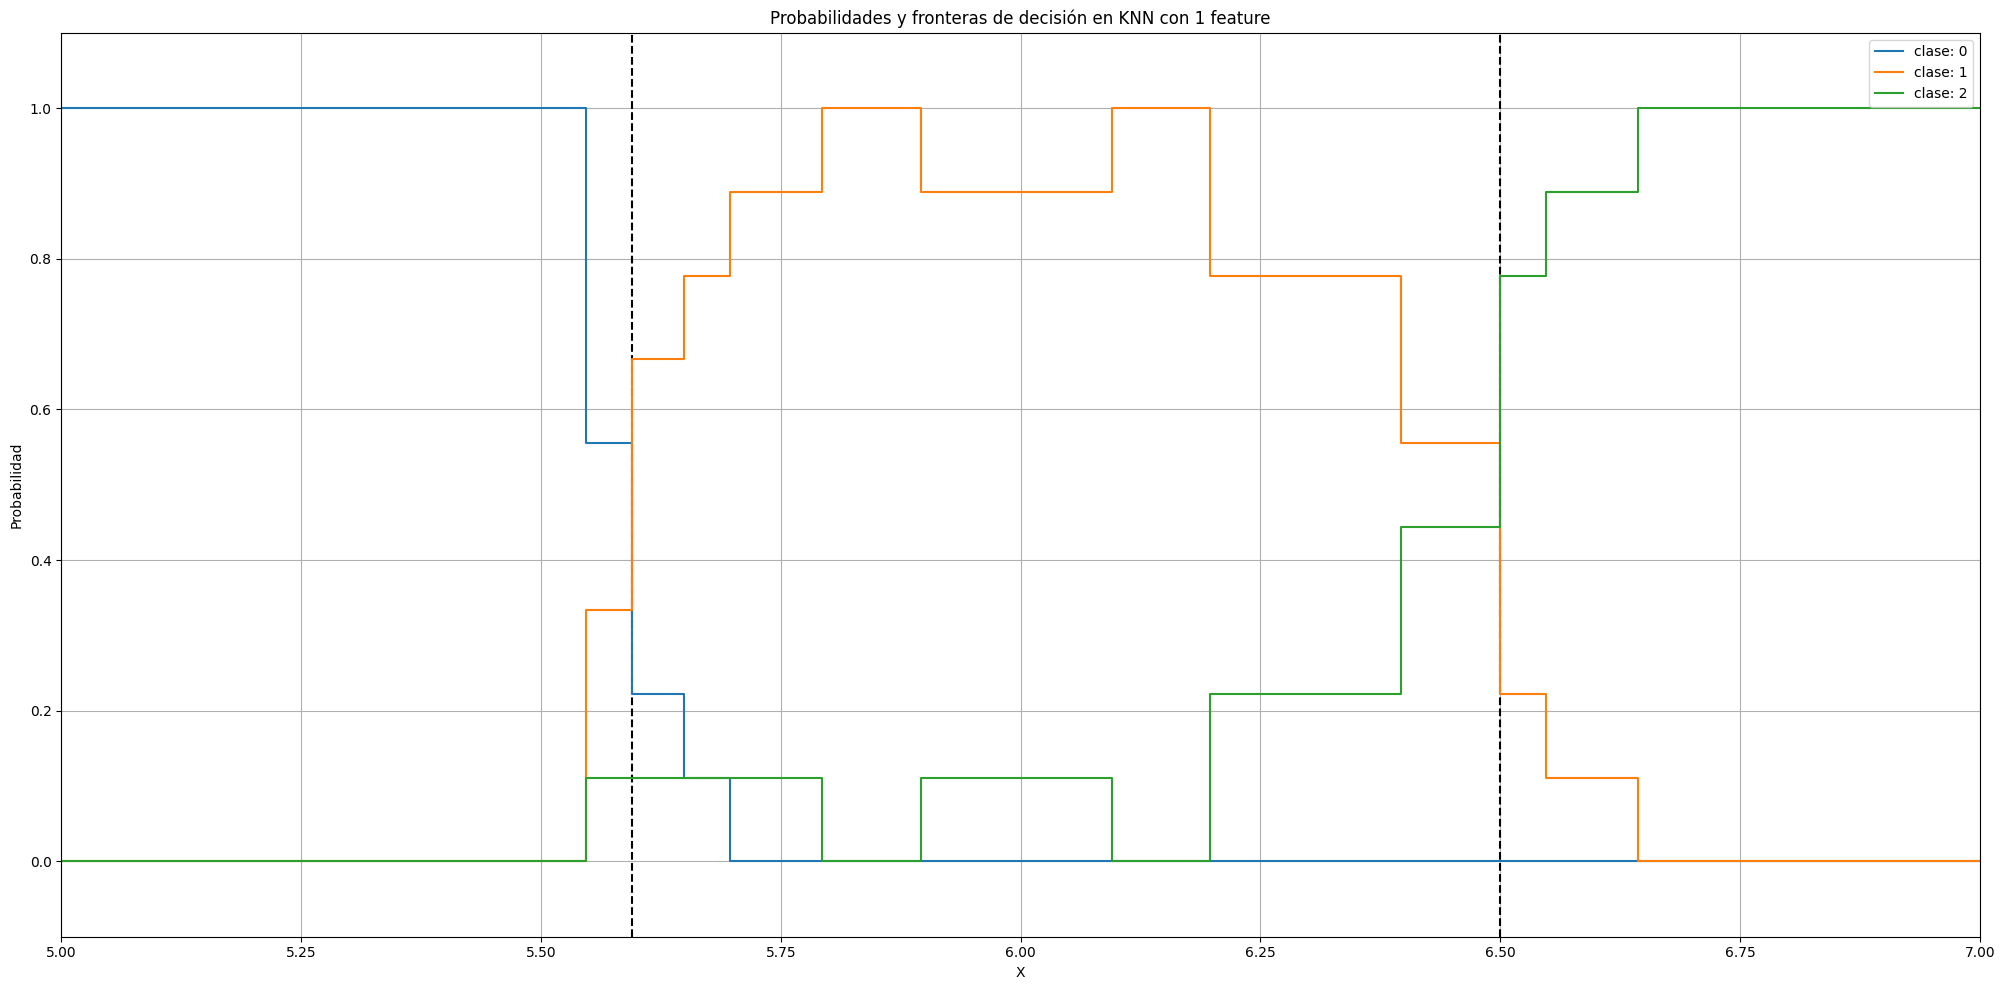

KNN: 
 accuracy = 0.9622641509433962 
 f1_macro = 0.9605020302694721
Matriz de confusión: [[21  0  0]
 [ 0 10  0]
 [ 1  1 20]]


In [972]:
k = 9
model_knn = KNN(k)

# print(x_train.shape, y_train.shape) #Para el chequeo de dimensiones

selected_feature_train = x_train['HbA1c']
selected_feature_test = x_test['HbA1c']

#Se entrena el modelo
model_knn.fit(selected_feature_train, y_train)

#Se grafica P(Y|X) para cada clase
x_graph = np.linspace(selected_feature_train.min(), selected_feature_train.max(), 2000).reshape(-1,1) #Se generan los datos para grafica

probs = model_knn.predict_proba(x_graph) #Se obtienen las predicciones soft, que son las probabilidades condicionales

y_pred_graph = model_knn.predict(x_graph)

index = np.where(np.diff(y_pred_graph) != 0)[0] #Se buscan los índices donde se cruzan los discriminantes (valores de la frontera)
x_edge = x_graph[index] #Se asignan las muestras de la frontera

plt.figure(figsize=(20, 10))

for x_e in x_edge: #Se grafican las fronteras de decisión
    plt.axvline(x_e, color='k', linestyle='--')

for c in range(probs.shape[1]): 
    plt.step(x_graph, probs[:,c],label=f'clase: {c}') #Se grafica la probabilidad condicional para cada clase
    plt.xlabel("X")
    plt.ylabel("Probabilidad")

plt.legend()
plt.title('Probabilidades y fronteras de decisión en KNN con 1 feature')
plt.tight_layout()
plt.xlim([5,7])
plt.ylim([-0.1,1.1])
plt.grid()
plt.show()


#Se obtiene la hard predict para los datos de testeo
y_pred = model_knn.predict(selected_feature_test)

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'KNN: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

print(f'Matriz de confusión: {c_matrix}')

En dicho gráfico, puede apreciarse que previo a 5.5 aproximadamente, domina la clase 0, a partir de dicho punto comienza a dominar la clase 1 y por último, la clase 2 domina en torno a 6.5. Dichos valores cambian debido a la separación azarosa previa, pero las fronteras de decisión se encontrarán cercanas a dichos valores en las muestras

Por otro lado, se puede observar en el accuracy que la precisión general es buena y mediante el macro-f1 y la matriz de confusión, que la precisión particular de cada clase, es buena, no hay una clase que tenga fallos muy marcados

## Entrenamiento y testeo para 2 features

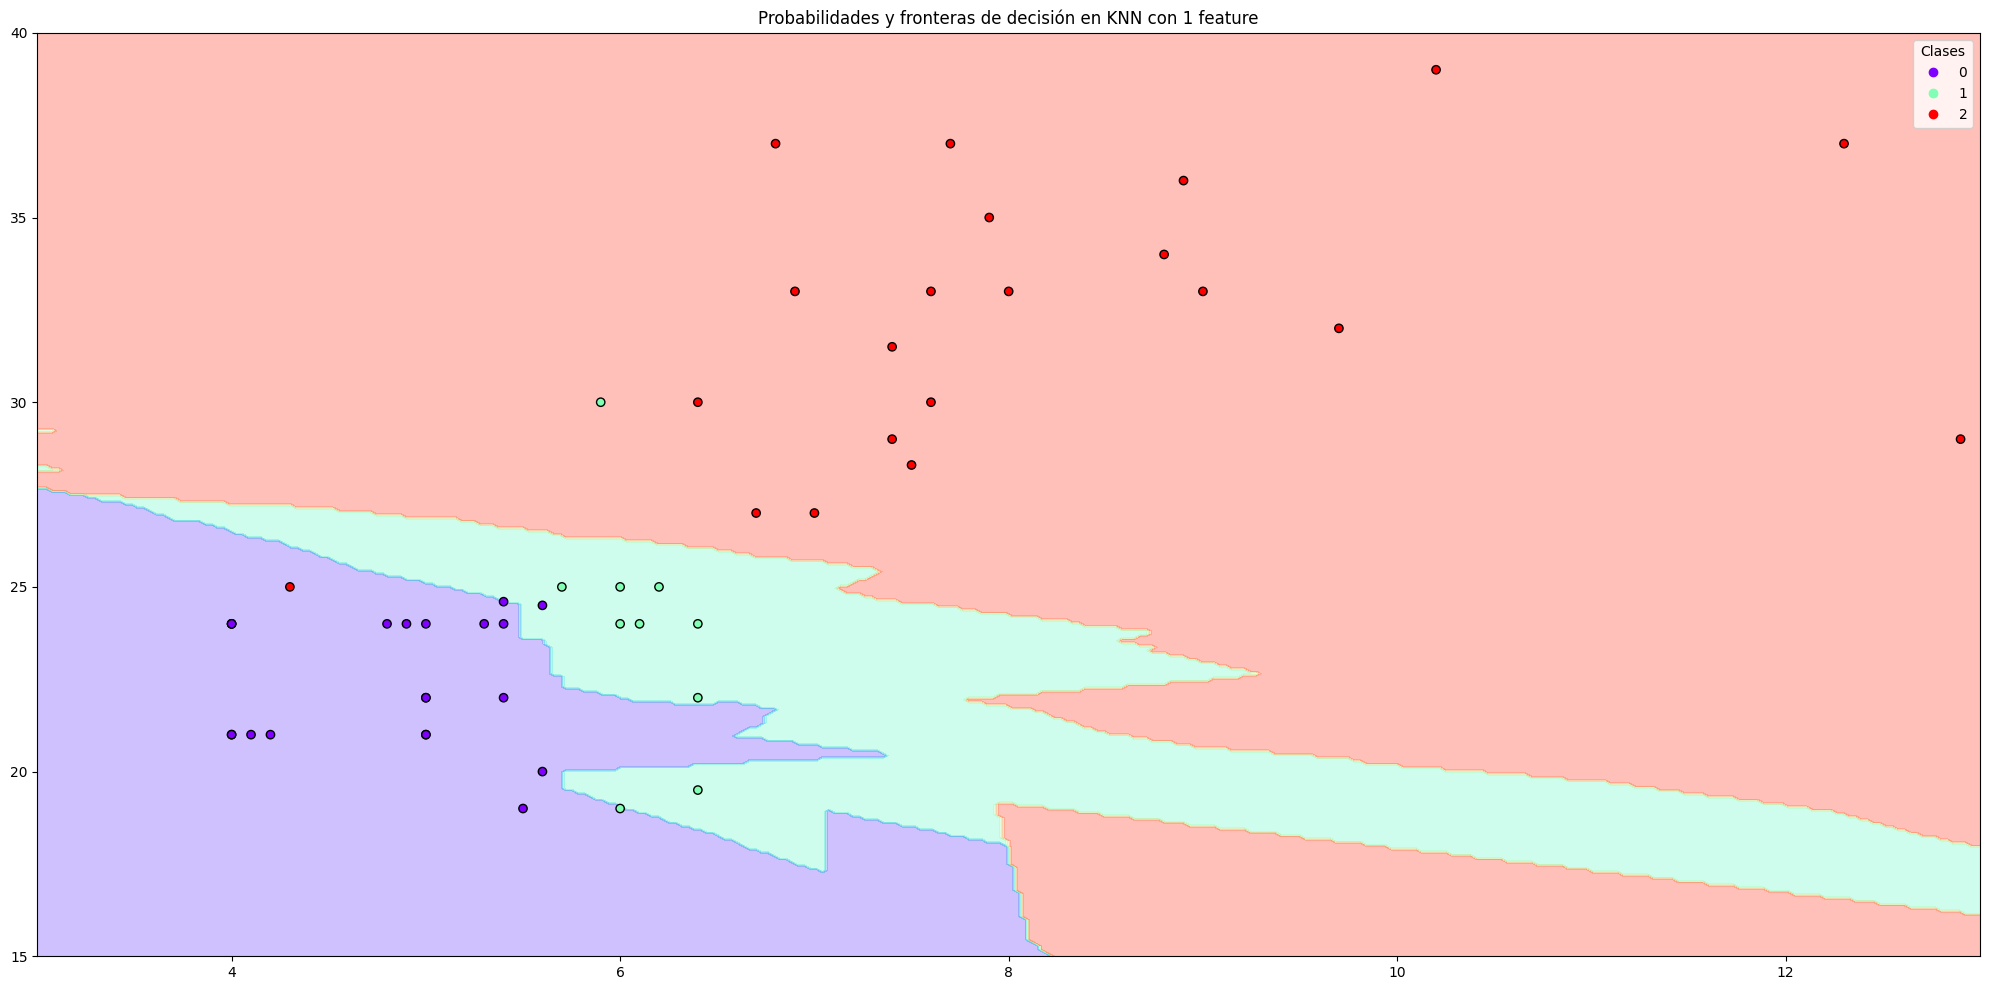

KNN: 
 accuracy = 0.9056603773584906 
 f1_macro = 0.8864357864357865
Matriz de confusión: [[19  2  0]
 [ 1  8  1]
 [ 1  0 21]]


In [973]:
k = 9
model_knn = KNN(k)

# print(x_train.shape, y_train.shape) #Para el chequeo de dimensiones

selected_feature_train = np.array(x_train[['HbA1c', 'BMI']])
selected_feature_test = np.array(x_test[['HbA1c', 'BMI']])

#Se entrena el modelo
model_knn.fit(selected_feature_train, y_train)

#Se crea la grilla para el gráfico de la frontera de decisión, utilizando como base los datos de entrenamiento
x1_min, x1_max = selected_feature_train[:,0].min()-1, selected_feature_train[:,0].max()+1
x2_min, x2_max = selected_feature_train.min()-1, selected_feature_train[:,1].max()+1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 500),
    np.linspace(x2_min, x2_max, 500)
)

grid_points = np.c_[xx1.ravel(), xx2.ravel()]

y_pred_graph = model_knn.predict(grid_points) #Se obtiene la hard predict para las muestras utilizadas en el gráfico
y_pred_graph = y_pred_graph.reshape(xx1.shape) #Se ajusta el tamaño del vector para tener el mismo shape que las columnas de la grilla

plt.figure(figsize=(20, 10))

#Se generan las zonas por clase
plt.contourf(xx1, xx2, y_pred_graph, alpha=0.3, cmap= 'rainbow')

#Se grafican las muestras reales de testeo
scatter=plt.scatter(selected_feature_test[:,0], selected_feature_test[:,1], c=y_test, edgecolors='k', cmap='rainbow')

plt.legend(*scatter.legend_elements(), title="Clases")
plt.title('Probabilidades y fronteras de decisión en KNN con 1 feature')
plt.tight_layout()
plt.xlim([3,13])
plt.ylim([15,40])
plt.show()

#Se obtiene la hard predict para los datos de testeo
y_pred = model_knn.predict(selected_feature_test)

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'KNN: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

print(f'Matriz de confusión: {c_matrix}')

En este caso, para 2 features, el modelo tiende a tener peor rendimiento, si bien no se genera un problema con respecto a una clase como en LDA, el accuracy general disminuyó

## Entrenamiento y testeo para todos los features

In [974]:
k = 9
model_knn = KNN(k)

# print(x_train.shape, y_train.shape) #Para el chequeo de dimensiones

selected_feature_train = np.array(x_train)
selected_feature_test = np.array(x_test)

#Se entrena el modelo
model_knn.fit(selected_feature_train, y_train)

#Se obtiene la hard predict para los datos de testeo
y_pred = model_knn.predict(selected_feature_test)

#Se obtiene el accuracy
accuracy = accuracy_score(y_test, y_pred)

#Se obtiene la matriz de confusión
c_matrix = confusion_matrix(y_test, y_pred)

#Se obtiene la macro-F1
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f'KNN: \n accuracy = {accuracy} \n f1_macro = {f1_macro}')

print(f'Matriz de confusión: {c_matrix}')

KNN: 
 accuracy = 0.6981132075471698 
 f1_macro = 0.6056847545219638
Matriz de confusión: [[16  3  2]
 [ 8  2  0]
 [ 3  0 19]]


En este último caso, es evidente que al agregar todos los features, el accuracy disminuyó de manera significativa. El resto de features no agrega información relevante, sino que genera ruido en el sistema disminuyendo la precisión en las predicciones. Hay mayor porcentaje de fallos